In [1]:
import Sokoban_env
from Sokoban_env import Sokoban_v2
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import rl_algorithms as rl

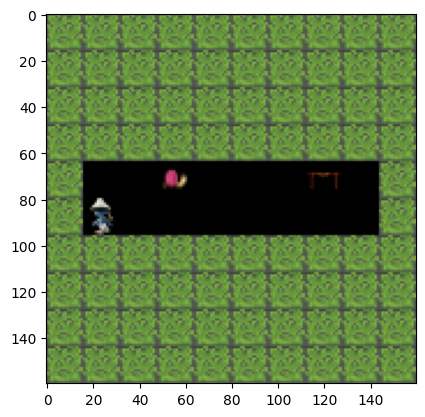

In [2]:
env = Sokoban_v2(map_name="level_2")
env.reset()
plt.imshow(env.render())

In [3]:
env.available_states(env)

[(4, 1),
 (4, 2),
 (4, 3),
 (4, 4),
 (4, 5),
 (4, 6),
 (4, 7),
 (4, 8),
 (5, 1),
 (5, 2),
 (5, 3),
 (5, 4),
 (5, 5),
 (5, 6),
 (5, 7),
 (5, 8)]

In [4]:
P = env.create_transition_pos()
P

{((4, 1), 1): [(5, 0.5), (1, 0.5)],
 ((4, 1), 3): [(4, 0.5), (2, 0.5)],
 ((4, 2), 1): [(5, 0.5), (2, 0.5)],
 ((4, 2), 2): [(4, 0.5), (1, 0.5)],
 ((4, 2), 3): [(4, 0.5), (3, 0.5)],
 ((4, 3), 1): [(5, 0.5), (3, 0.5)],
 ((4, 3), 2): [(4, 0.5), (2, 0.5)],
 ((4, 3), 3): [(4, 0.5), (4, 0.5)],
 ((4, 4), 1): [(5, 0.5), (4, 0.5)],
 ((4, 4), 2): [(4, 0.5), (3, 0.5)],
 ((4, 4), 3): [(4, 0.5), (5, 0.5)],
 ((4, 5), 1): [(5, 0.5), (5, 0.5)],
 ((4, 5), 2): [(4, 0.5), (4, 0.5)],
 ((4, 5), 3): [(4, 0.5), (6, 0.5)],
 ((4, 6), 1): [(5, 0.5), (6, 0.5)],
 ((4, 6), 2): [(4, 0.5), (5, 0.5)],
 ((4, 6), 3): [(4, 0.5), (7, 0.5)],
 ((4, 7), 1): [(5, 0.5), (7, 0.5)],
 ((4, 7), 2): [(4, 0.5), (6, 0.5)],
 ((4, 7), 3): [(4, 0.5), (8, 0.5)],
 ((4, 8), 1): [(5, 0.5), (8, 0.5)],
 ((4, 8), 2): [(4, 0.5), (7, 0.5)],
 ((5, 1), 0): [(4, 0.5), (1, 0.5)],
 ((5, 1), 3): [(5, 0.5), (2, 0.5)],
 ((5, 2), 0): [(4, 0.5), (2, 0.5)],
 ((5, 2), 2): [(5, 0.5), (1, 0.5)],
 ((5, 2), 3): [(5, 0.5), (3, 0.5)],
 ((5, 3), 0): [(4, 0.5), (3,

In [5]:
env.room_state.shape

(10, 10)

In [10]:
def value_iteration(env,num_iterations = 100,threshold = 1e-20,gamma = 1.0):
    state_space = env.observation_space.n
    action_space = env.action_space.n
    value_table = np.zeros(state_space)

    for i in range(num_iterations):
        update_value_table = np.copy(value_table)

        for state in range(state_space):
            Q_values = []
            for action in range(action_space):
                transitions = env.P.get((state, action), [])  # Get possible transitions for (state, action)
                q_value = 0.0
                for next_state, prob in transitions:
                    reward = env.R.get((state, action, next_state), 0.0)  # Get the reward for the transition
                    q_value += prob * (reward + gamma * update_value_table[next_state])
                Q_values.append(q_value)

            value_table[state] = max(Q_values)

        if np.sum(np.fabs(update_value_table - value_table)) <= threshold:
            break

    return value_table


def extract_policy(value_table, env):
    gamma = 1.0
    policy = np.zeros(env.observation_space.n, dtype=int)

    for state in range(env.observation_space.n):
        Q_values = []
        for action in range(env.action_space.n):
            transitions = env.P.get((state, action), [])  # Get possible transitions for (state, action)
            q_value = 0.0
            for next_state, prob in transitions:
                reward = env.R.get((state, action, next_state), 0.0)  # Get the reward for the transition
                q_value += prob * (reward + gamma * value_table[next_state])
            Q_values.append(q_value)

        policy[state] = np.argmax(Q_values)

    return policy


In [11]:
optimal_value_function = value_iteration(env)
optimal_policy = extract_policy(optimal_value_function,env)
print(optimal_policy)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [12]:
def policy_iteration(env, num_iterations=100, gamma=1.0):
    state_space = env.observation_space.n
    action_space = env.action_space.n
    policy = np.random.choice(action_space, size=state_space)

    for _ in range(num_iterations):
        value_table = np.zeros(state_space)
        threshold = 1e-20

        while True:
            update_value_table = np.copy(value_table)
            for state in range(state_space):
                action = policy[state]
                transitions = env.P.get((state, action), [])
                v = 0.0
                for next_state, prob in transitions:
                    reward = env.R.get((state, action, next_state), 0.0)
                    v += prob * (reward + gamma * update_value_table[next_state])
                value_table[state] = v

            if np.sum(np.fabs(update_value_table - value_table)) <= threshold:
                break

        # Policy Improvement
        policy_stable = True
        for state in range(state_space):
            old_action = policy[state]
            Q_values = np.zeros(action_space)
            for action in range(action_space):
                transitions = env.P.get((state, action), [])
                q_value = 0.0
                for next_state, prob in transitions:
                    reward = env.R.get((state, action, next_state), 0.0)
                    q_value += prob * (reward + gamma * value_table[next_state])
                Q_values[action] = q_value

            best_action = np.argmax(Q_values)
            policy[state] = best_action

            if old_action != best_action:
                policy_stable = False

        if policy_stable:
            break

    return policy


In [14]:
optimal_policy = policy_iteration(env)
optimal_policy

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])